# Linear Regression
### by [Richard W. Evans](https://sites.google.com/site/rickecon/), February 2019
This Jupyter notebook is an adaptation of the QuantEcon Lecture, "[Linear Regression in Python](https://lectures.quantecon.org/py/ols.html)" by [Natasha Watkins](https://github.com/natashawatkins). The code in this Jupyter notebook was written using Python 3.6. It uses data files `maketable1.dta`, `maketable2.dta`, and `maketable4.dta` that are retrieved from the QuantEcon repository. For the code to run properly, you will either need to have access to the internet or you should have the data file in the same folder as the Jupyter notebook file. Otherwise, you will have to change the respective lines of the code that read in the data to reflect the location of that data.

## 1. An example analysis: Acemoglu, et al (2001)
The research question of the paper [AJR01] is to determine whether or not differences in institutions can help to explain observed economic outcomes. How do we measure institutional differences and economic outcomes? In this paper:
* economic outcomes are proxied by log GDP per capita in 1995, adjusted for exchange rates,
* institutional differences are proxied by an index of protection against expropriation on average over 1985-95, constructed by the [Political Risk Serivces Group](https://www.prsgroup.com/).

These variables and other data used in the paper are available for download on [Daron Acemoglu’s webpage](https://economics.mit.edu/faculty/acemoglu/data/ajr2001).

## 2. Initial data description
We will use pandas’ `.read_stata()` function to read in data contained in the `.dta` files to dataframes.

In [1]:
import pandas as pd

df1 = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/' +
                    'raw/master/ols/maketable1.dta')
# The pandas DataFrame.head() method returns the first N rows of a DataFrame
# with column headings and index numbers. The default is N=5.
df1.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let’s use a scatterplot to see whether any obvious relationship exists between GDP per capita and the protection against expropriation index.

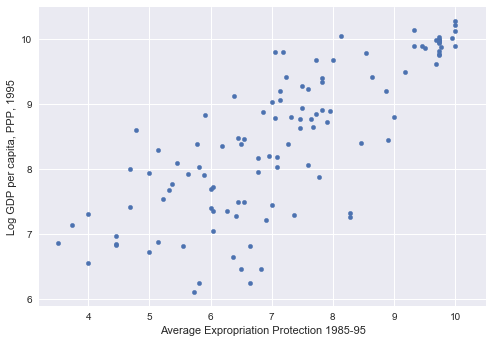

In [3]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

df1.plot(x='avexpr', y='logpgp95', kind='scatter')
plt.xlabel(r'Average Expropriation Protection 1985-95')
plt.ylabel(r'Log GDP per capita, PPP, 1995')
plt.xlim((3.2, 10.5))
plt.ylim((5.9, 10.5))
plt.show()

The plot shows a fairly strong positive relationship between protection against expropriation and log GDP per capita. Specifically, if higher protection against expropriation is a measure of institutional quality, then better institutions appear to be positively correlated with better economic outcomes (higher GDP per capita).

## 3. Running a linear regression
Given the plot above, choosing a linear model to describe this relationship seems like a reasonable assumption.

We can write a model as,
$$logpgp95_i = \beta_0 + \beta_1 avexpr_i + u_i $$
where:
* $\beta_0$ is the intercept of the linear trend line on the $y$-axis
* $\beta_1$ is the slope of the linear trend line, representing the marginal effect of protection against risk on log GDP per capita
* $u_i$ is a random error term (deviations of observations from the linear trend due to factors not included in the model)

Visually, this linear model involves choosing a straight line that best fits the data, as in the following plot (Figure 2 in [AJR01]).

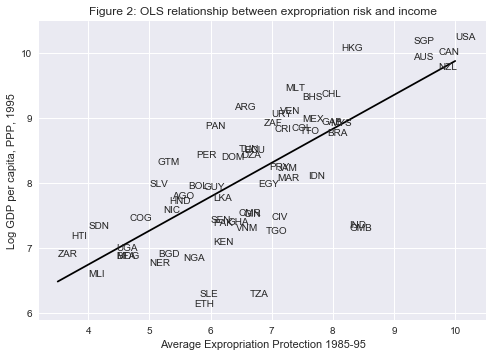

In [4]:
import numpy as np

# Dropping NA's is required to use numpy's polyfit
df1_subset = df1.dropna(subset=['logpgp95', 'avexpr'])

# Use only 'base sample' for plotting purposes (smaller sample)
df1_subset = df1_subset[df1_subset['baseco'] == 1]

X = df1_subset['avexpr']
y = df1_subset['logpgp95']
labels = df1_subset['shortnam']

# Replace markers with country labels
plt.scatter(X, y, marker='')

for i, label in enumerate(labels):
    plt.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
plt.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')

plt.xlabel('Average Expropriation Protection 1985-95')
plt.ylabel('Log GDP per capita, PPP, 1995')
plt.xlim((3.2, 10.5))
plt.ylim((5.9, 10.5))
plt.title('Figure 2: OLS relationship between expropriation risk and income')
plt.show()

The most common technique to estimate the parameters (ββ‘s) of the linear model is Ordinary Least Squares (OLS). As the name implies, an OLS model is solved by finding the parameters that minimize the sum of squared residuals.
$$ \hat{\beta}_{OLS} = \beta : \quad \min_{\beta}\: u(X|\beta_0,\beta_1)^T \: u(X|\beta_0,\beta_1) $$

where $\hat{u}_i$ is the difference between the dependent variable observation $logpgp95_i$ and the predicted value of the dependent variable $\beta_0 + \beta_1 avexpr_i$. To estimate the constant term $\beta_0$, we need to add a column of 1’s to our dataset (consider the equation if $\beta_0$ was replaced with $\beta_0 x_i$ where $x_i=1$).

In [5]:
df1['const'] = 1

Now we can construct our model using the `statsmodels` module and the `OLS` method. We will use `pandas` DataFrames with `statsmodels`. However, standard arrays can also be used as arguments.

In [6]:
# Ignore the warning that comes up. Most issue boards suggest that this module is not
# really depreciated
import statsmodels.api as sm

reg1 = sm.OLS(endog=df1['logpgp95'], exog=df1[['const', 'avexpr']], missing='drop')
type(reg1)

statsmodels.regression.linear_model.OLS

So far we have simply constructed our model. The `statsmodels.regression.linear_model.OLS` is simply an object specifying dependent and independent variables, as well as instructions about what to do with missing data. We need to use the `.fit()` method to obtain OLS parameter estimates $\hat{\beta}_0$ and $\hat{\beta}_1$. This method calculates the OLS coefficients according to the minimization problem,
$$ \hat{\beta}_{OLS} = \beta : \quad \min_{\beta}\: u(X|\beta_0,\beta_1)^T \: u(X|\beta_0,\beta_1) $$

In [7]:
results = reg1.fit()
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

We now have the fitted regression model stored in `results` (see [statsmodels.regression.linear_model.RegressionResults](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html)). The `results` from the `reg1.fit()` command is a regression results object with a lot of information, similar to the results object of the `scipy.optimize.minimize()` function we worked with in the MLE and GMM notebooks.

To view the OLS regression results, we can call the `.summary()` method.

[Note that an observation was mistakenly dropped from the results in the original paper (see the note located in maketable2.do from Acemoglu’s webpage), and thus the coefficients differ slightly.]

In [8]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     171.4
Date:                Wed, 13 Feb 2019   Prob (F-statistic):           4.16e-24
Time:                        11:01:49   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6261      0.301     15.391      0.0

## 4. Interpreting results and output
From our results, we see that:
* the intercept $\hat{\beta}_0=4.63$ (interpretation?)
* the slope $\hat{\beta}_1=0.53$ (interpretation?)
* the positive $\hat{\beta}_1>0$ parameter estimate implies that protection from expropriation has a positive effect on economic outcomes, as we saw in the figure.
* How would you quantitatively interpret the $\hat{\beta}_1$ coefficient?
* What do the standard errors on the coefficients tell you?
* The p-value of 0.000 for $\hat{\beta}_1$ implies that the effect of institutions on GDP is statistically significant (using $p < 0.05$ as a rejection rule)
* The R-squared value of 0.611 indicates that around 61% of variation in log GDP per capita is explained by protection against expropriation

Using our parameter estimates, we can now write our estimated relationship as
$$ \hat{logpgp95}_i = 4.63 + 0.53 avexpr_i $$

This equation describes the line that best fits our data, as shown in Figure 2. We can use this equation to predict the level of log GDP per capita for a value of the index of expropriation protection.

### 4.1 Analysis of variance (ANOVA) output
The results `.summary()` method provides a lot of regression output. And the `.RegressionResults` object has much more as evidenced in the help page [statsmodels.regression.linear_model.RegressionResults](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html).

* The `Df Residuals: 109` displays the degrees of freedom from the residual variance calculation. This equals the number of observations minus the number of regression coefficients, `N-p=111-2`. This is accessed with `results.df_resid`.
* The `Df Model: 1` displays the degrees of freedom from the model variance calculation or from the regressors. This equals the number of regression coefficients minus one, `p-1=2-1`. This is accessed with `results.df_model`.
* One can specify robust standard errors in their regression. The robust option is specified in the `.fit()` command. You can specify three different types of robust standard errors using the `.fit(cov_type='HC1')`, `.fit(cov_type='HC2')`, or `.fit(cov_type='HC3')` options.
* You can do clustered standard errors if you have groups labeled in a variable called `mygroups` by using the `.fit(cov_type='cluster', cov_kwds={'groups': mygroups})`.
* R-squared is a measure of fit of the overall model. It is $R^2=1 - SSR/SST$ where $SST$ is the total variance of the dependent variable (total sum of squares), and $SSR$ is the sum of squared residuals (variance of the residuals). Another expresion is the sum of squared predicted values over the total sum of squares $R^2= SSM/SST$, where $SSM$ is the sum of squared predicted values. This is accessed with `results.rsquared`.
* Adjusted R-squared is a measure of fit of the overall model that penalizes extra regressors. A property of the R-squared in the previous bullet is that it always increases as you add more explanatory variables. This is accessed with `results.rsquared_adj`.

### 4.2 F-test and log likelihood
* The F-statistic is the statistic from an F-test of the joint hypothesis that all the coefficients are equal to zero. The value of the F-statistic is distributed according to the F-distribution $F(d1,d2)$, where $d1=p-1$ and $d2=N-p$.
* The Prob (F-statistic) is the probability that the null hypothesis of all the coefficients being zero is true. In this case, it is really small.
* Log-likelihood is the sum of the log pdf values of the errors given their being normally distributed with mean 0 and standard deviation implied by the OLS estimates.

### 4.3 Inference on individual parameters
* The estimated coefficients of the linear regression are reported in the `results.params` vector object (pandas Series).
* The standard error on each estimated coefficient is reported in the summary results column entitled `std err`. These standard errors are reported in the `results.bse` vector object (pandas Series).
* The "t" column is the $t$ test statistic. It is the value in the support of the students-T distribution that is equivalent to the estimated coefficient if the null-hypothesis were true that the estimated coefficient were 0.
* The reported p-value is the probability of a two-sided t-test that gives the probability that the estimated coefficient is greater than its estimated value if the true value were 0. A more intuitive interpretation is the probability of seeing that estimated value if the null hypothesis were true. We usually reject the null hypothesis if the p-value is lower than 0.05.
* The summary results report the 95% two-sided confidence interval for the estimated value.

## 5. Predicted values
We can obtain an array of predicted $logpgp95_i$ for every value of $avexpr_i$ in our dataset by calling `.predict()` on our results. Let's first get the predicted value for the average country in the dataset. 

In [9]:
mean_expr = np.mean(df1['avexpr'])
mean_expr

7.066490173339844

```none
6.515625
```


In [10]:
predicted_logpdp95 = 4.63 + 0.53 * 7.06
predicted_logpdp95

8.3718

An easier (and more accurate) way to obtain this result is to use `.predict()` and set $constant=1$ and $avexpr_i=$ `mean_expr`.

In [11]:
results.predict(exog=[1, mean_expr])

array([8.38455307])

Plotting the predicted values against $avexpr_i$ shows that the predicted values lie along the linear line that we fitted below in Figure 3. The observed values of $logpgp95_i$ are also plotted for comparison purposes.

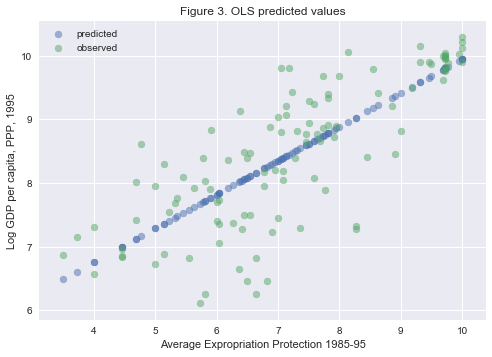

In [12]:
# Drop missing observations from whole sample

df1_plot = df1.dropna(subset=['logpgp95', 'avexpr'])

# Plot predicted values. alpha is a blending value between 0 (transparent) and 1 (opaque)
plt.scatter(df1_plot['avexpr'], results.predict(), alpha=0.5, label='predicted')

# Plot observed values
plt.scatter(df1_plot['avexpr'], df1_plot['logpgp95'], alpha=0.5, label='observed')

plt.legend()
plt.title('Figure 3. OLS predicted values')
plt.xlabel('Average Expropriation Protection 1985-95')
plt.ylabel('Log GDP per capita, PPP, 1995')
plt.show()

## 6. Extending the linear regression model
So far we have only accounted for institutions affecting economic performance. Almost certainly there are numerous other factors affecting GDP that are not included in our model. Leaving out variables that affect $logpgp95_i$ will result in **omitted variable bias**, yielding biased and inconsistent parameter estimates. We can extend our bivariate regression model to a **multivariate regression model** by adding in other factors that may affect $logpgp95_i$.

[AJR01] consider other factors such as:
* the effect of climate on economic outcomes; latitude is used to proxy this
* differences that affect both economic performance and institutions, eg. cultural, historical, etc.; controlled for with the use of continent dummies

Let’s estimate some of the extended models considered in the paper (Table 2) using data from `maketable2.dta`.

In [13]:
df2 = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/' +
                    'raw/master/ols/maketable2.dta')

# Add constant term to dataset
df2['const'] = 1

# Create lists of variables to be used in each regression
X1 = ['const', 'avexpr']
X2 = ['const', 'avexpr', 'lat_abst']
X3 = ['const', 'avexpr', 'lat_abst', 'asia', 'africa', 'other']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df2['logpgp95'], df2[X1], missing='drop').fit()
reg2 = sm.OLS(df2['logpgp95'], df2[X2], missing='drop').fit()
reg3 = sm.OLS(df2['logpgp95'], df2[X3], missing='drop').fit()

Now that we have fitted our model, we will use the `summary_col` module to display the results in a single table (model numbers correspond to those in the paper).

In [14]:
from statsmodels.iolib.summary2 import summary_col

info_dict={'R-squared' : lambda x: "{:.2f}".format(x.rsquared),
           'No. observations' : lambda x: "{0:d}".format(int(x.nobs))}

results_table = summary_col(results=[reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 3',
                                         'Model 4'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'avexpr',
                                             'lat_abst',
                                             'asia',
                                             'africa',
                                             'other'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

        Table 2 - OLS Regressions
                 Model 1 Model 3 Model 4 
-----------------------------------------
const            4.63*** 4.87*** 5.85*** 
                 (0.30)  (0.33)  (0.34)  
avexpr           0.53*** 0.46*** 0.39*** 
                 (0.04)  (0.06)  (0.05)  
lat_abst                 0.87*   0.33    
                         (0.49)  (0.45)  
asia                             -0.15   
                                 (0.15)  
africa                           -0.92***
                                 (0.17)  
other                            0.30    
                                 (0.37)  
R-squared        0.61    0.62    0.72    
No. observations 111     111     111     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## 7. Endogeneity, Ommitted Variable Bias, Instrumental Variables
As [AJR01] discuss, the OLS models likely suffer from endogeneity issues, resulting in biased and inconsistent model estimates. Namely, there is likely a two-way relationship between institutions and economic outcomes.
* richer countries may be able to afford or prefer better institutions
* variables that affect income may also be correlated with institutional differences
* the construction of the index may be biased; analysts may be biased towards seeing countries with higher income having better institutions

To deal with endogeneity, we can use two-stage least squares (2SLS) regression, which is an extension of OLS regression. It is also a form of instrumental variables (IV) regression. This method requires replacing the endogenous variable $avexpr_i$ with a variable that is:
* correlated with $avexpr_i$
* not correlated with the error term (ie. it should not directly affect the dependent variable, otherwise it would be correlated with $u_i$ due to omitted variable bias)

The new set of regressors are called instruments, which aim to remove endogeneity in our proxy of institutional differences. The main contribution of [AJR01] is the use of settler mortality rates to instrument for institutional differences. They hypothesize that higher mortality rates of colonizers led to the establishment of institutions that were more extractive in nature (less protection against expropriation), and these institutions still persist today.

Using a scatterplot (Figure 3 in [AJR01]), we can see protection against expropriation is negatively correlated with settler mortality rates, coinciding with the authors’ hypothesis and satisfying the first condition of a valid instrument.

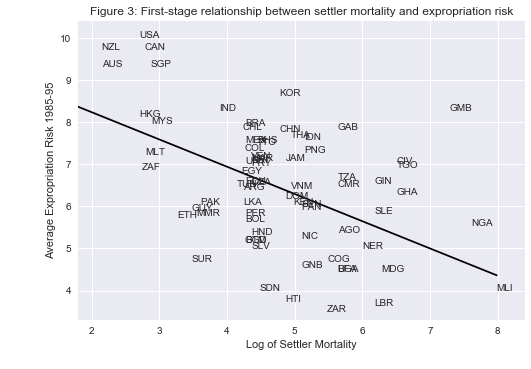

In [16]:
# Dropping NA's is required to use numpy's polyfit
df1_subset2 = df1.dropna(subset=['logem4', 'avexpr'])

X = df1_subset2['logem4']
y = df1_subset2['avexpr']
labels = df1_subset2['shortnam']

# Replace markers with country labels
plt.scatter(X, y, marker='')

for i, label in enumerate(labels):
    plt.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
plt.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')

plt.xlim([1.8,8.4])
plt.ylim([3.3,10.4])
plt.xlabel('Log of Settler Mortality')
plt.ylabel('Average Expropriation Risk 1985-95')
plt.title('Figure 3: First-stage relationship between settler ' +
          'mortality and expropriation risk')
plt.show()

The second condition may not be satisifed if settler mortality rates in the 17th to 19th centuries have a direct effect on current GDP (in addition to their indirect effect through institutions). For example, settler mortality rates may be related to the current disease environment in a country, which could affect current economic performance.

[AJR01] argue this is unlikely because:

* The majority of settler deaths were due to malaria and yellow fever, and had limited effect on local people.
* The disease burden on local people in Africa or India, for example, did not appear to be higher than average, supported by relatively high population densities in these areas before colonization.

As we appear to have a valid instrument, we can use 2SLS regression to obtain consistent and unbiased parameter estimates.

**First stage**

The first stage involves regressing the endogenous variable ($avexpr_i$) on the instruments. The instruments consist of the new variable that is correlated with $avexpr_i$ as well as all the other exogenous variables in our model (and not just the variable we have replaced). Using model 1 as an example, our set of instruments is simply a constant and settler mortality rates $logem4_i$. Therefore, we will estimate the first-stage regression as:

$$ avexpr_i= \delta_0 + \delta_1 logem4_i + v_i $$

The data we need to estimate this equation is located in maketable4.dta (only complete data, indicated by `baseco = 1`, is used for estimation).

In [17]:
# Import and select the data
df4 = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/' +
                    'raw/master/ols/maketable4.dta')
df4 = df4[df4['baseco'] == 1]

# Add a constant variable
df4['const'] = 1

# Fit the first stage regression and print summary
results_fs = sm.OLS(df4['avexpr'],
                    df4[['const', 'logem4']],
                    missing='drop').fit()
print(results_fs.summary())

                            OLS Regression Results                            
Dep. Variable:                 avexpr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     22.95
Date:                Wed, 13 Feb 2019   Prob (F-statistic):           1.08e-05
Time:                        11:05:47   Log-Likelihood:                -104.83
No. Observations:                  64   AIC:                             213.7
Df Residuals:                      62   BIC:                             218.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3414      0.611     15.296      0.0

**Second stage**

We need to retrieve the predicted values of $avexpr_i$ using `.predict()`. We then replace the endogenous variable $avexpr_i$ with the predicted values $\hat{avexpr}_i$ in the original linear model. Our second stage regression is thus:

$$ logpgp95_i = \beta_0 + \beta_1 \hat{avexpr}_i + u_i $$

In [18]:
df4['predicted_avexpr'] = results_fs.predict()

results_ss = sm.OLS(df4['logpgp95'],
                    df4[['const', 'predicted_avexpr']]).fit()
print(results_ss.summary())
df4['avexpr'].describe()

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     56.60
Date:                Wed, 13 Feb 2019   Prob (F-statistic):           2.66e-10
Time:                        11:05:54   Log-Likelihood:                -72.268
No. Observations:                  64   AIC:                             148.5
Df Residuals:                      62   BIC:                             152.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9097      0.823  

count    64.000000
mean      6.515625
std       1.468647
min       3.500000
25%       5.613636
50%       6.477273
75%       7.352273
max      10.000000
Name: avexpr, dtype: float64

The second-stage regression results give us an unbiased and consistent estimate of the effect of institutions on economic outcomes. The result suggests a stronger positive relationship than what the OLS results indicated.

Note that while our parameter estimates are correct, our standard errors are not and for this reason, computing 2SLS ‘manually’ (in stages with OLS) is not recommended. We can correctly estimate a 2SLS regression in one step using the [linearmodels](https://github.com/bashtage/linearmodels) package, an extension of `statsmodels`.

To install this package, you will need to run `pip install linearmodels` in your command line.

In [19]:
from linearmodels.iv import IV2SLS

Note that when using `IV2SLS`, the exogenous and instrument variables are split up in the function arguments (whereas before the instrument included exogenous variables).

In [20]:
iv = IV2SLS(dependent=df4['logpgp95'],
            exog=df4['const'],
            endog=df4['avexpr'],
            instruments=df4['logem4']).fit(cov_type='unadjusted')

print(iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               logpgp95   R-squared:                      0.1870
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1739
No. Observations:                  64   F-statistic:                    37.568
Date:                Wed, Feb 13 2019   P-value (F-stat)                0.0000
Time:                        11:06:02   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          1.9097     1.0106     1.8897     0.0588     -0.0710      3.8903
avexpr         0.9443     0.1541     6.1293     0.00

Given that we now have consistent and unbiased estimates, we can infer from the model we have estimated that institutional differences (stemming from institutions set up during colonization) can help to explain differences in income levels across countries today.

[AJR01] use a marginal effect of 0.94 to calculate that the difference in the index between Chile and Nigeria (ie. institutional quality) implies up to a 7-fold difference in income, emphasizing the significance of institutions in economic development.

## 8. Weighted Least Squares (WLS)
[TODO: Include this.]

## 9. References
* [AJR01] Daron Acemoglu, Simon Johnson, and James A Robinson. The colonial origins of comparative development: an empirical investigation." *The American Economic Review*, 91(5):1369–1401, 2001.